# Quantized Kernel Least Mean Sqares

For the eye activation detection task, there is a clear trend in the data - measuring the data with open eyes outputs a clearly different DC Voltage than measuring the data with eyes closed. This can be observed in the sample data below.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Digilent WaveForms Oscilloscope Acquisition
#Device Name: Discovery2
#Serial Number: SN:210321B5D9FA
#Date Time: 2025-02-13 12:33:16.223
#Sample rate: 136.533Hz
#Samples: 5800
#Trigger: Source: Channel 1 Type: Edge Condition: Rising Level: 0 V Hyst.: Auto HoldOff: 0 s
#Channel 1: Range: 200 mV/div Offset: -2 V Sample Mode: Average
#Channel 2: Range: 500 mV/div Offset: 0 V Sample Mode: Average
#Power Supplies: ON
#Positive Supply: ON
#Voltage: 5 V
#Negative Supply: ON
#Voltage: -5 V

## QKLMS Calculations

In [3]:
def gaussian_kernel(u, v, sigma):
    """
    Computes the Gaussian kernel between vectors u and v.
    
    u, v: Input vectors (numpy arrays)
    sigma: Kernel width (scalar)
    
    Returns:
        Kernel value (scalar)
    """
    return np.exp(- np.linalg.norm(u - v)**2 / (2 * sigma**2))
def apply_qklms(u_i, d_i, codebook, coeffs, eta, sigma, epsilon):
    """
    Applies one update of the QKLMS algorithm for a single sample (u_i, d_i).
    
    u_i: Current input sample (numpy array)
    d_i: Desired output for the current sample (scalar)
    codebook: List of current centers (each a numpy array)
    coeffs: List of coefficients corresponding to the centers in codebook
    eta: Step size (learning rate)
    sigma: Kernel width for the Gaussian kernel
    epsilon: Quantization threshold (quantization size)
    
    Returns:
        y_hat: Filter output for u_i (scalar)
        codebook: Updated list of centers
        coeffs: Updated list of coefficients
        e: Error for the current sample (scalar)
    """
    # Compute filter output: y_hat = sum_j coeffs[j]*kernel(codebook[j], u_i)
    y_hat = 0.0
    for j, center in enumerate(codebook):
        y_hat += coeffs[j] * gaussian_kernel(center, u_i, sigma)
    
    # Compute error between desired and estimated output
    e = d_i - y_hat
    
    # Compute Euclidean distances between u_i and each codebook center
    distances = np.array([np.linalg.norm(u_i - center) for center in codebook])
    
    # Find the closest center and its distance
    min_dist = np.min(distances)
    j_star = np.argmin(distances)
    
    # If the minimum distance is within the threshold, update the coefficient
    if min_dist <= epsilon:
        coeffs[j_star] += eta * e
    else:
        # Otherwise, add u_i as a new center with initial coefficient eta*e
        codebook.append(u_i.copy())
        coeffs.append(eta * e)
    
    return y_hat, codebook, coeffs, e
def qklms_filter(u, d, eta, sigma, epsilon):
    """
    Implements the QKLMS algorithm for kernel adaptive filtering.
    
    u: Input signals, a numpy array of shape (N, input_dim) where each row is a sample.
    d: Desired output signals, a numpy array of shape (N,).
    eta: Step size (learning rate)
    sigma: Gaussian kernel width
    epsilon: Quantization threshold
    
    Returns:
        y_hat: Array of filter outputs (shape: (N,))
        final_codebook: Final list of centers (codebook)
        final_coeffs: Final list of coefficients corresponding to centers
        e_history: Array of errors for each sample (shape: (N,))
        codebook_history: List of codebooks at each iteration (for tracking, optional)
        coeffs_history: List of coefficients arrays at each iteration (for tracking, optional)
    """
    N = u.shape[0]
    # Initialize the codebook with the first sample and corresponding coefficient
    codebook = [u[0].copy()]
    coeffs = [eta * d[0]]
    
    # Initialize arrays for outputs and errors
    y_hat = np.zeros(N)
    e_history = np.zeros(N)
    
    # Optionally track the evolution of the codebook and coefficients
    codebook_history = [codebook.copy()]
    coeffs_history = [coeffs.copy()]
    
    # Process the first sample (can be seen as a "training" initialization)
    y_hat[0] = coeffs[0] * gaussian_kernel(codebook[0], u[0], sigma)
    e_history[0] = d[0] - y_hat[0]
    
    # Process subsequent samples
    for i in range(1, N):
        y_hat[i], codebook, coeffs, e = apply_qklms(u[i], d[i], codebook, coeffs, eta, sigma, epsilon)
        e_history[i] = e
        codebook_history.append(codebook.copy())
        coeffs_history.append(coeffs.copy())
        
    return y_hat, codebook, coeffs, e_history, codebook_history, coeffs_history


## QKLMS Prototype Experiments (Python)

#### QKLMS

NMSE for eye_blinking0.csv: 0.02532629483002083
Training on file eye_blinking0.csv
Final number of centers in QKLMS codebook: 1


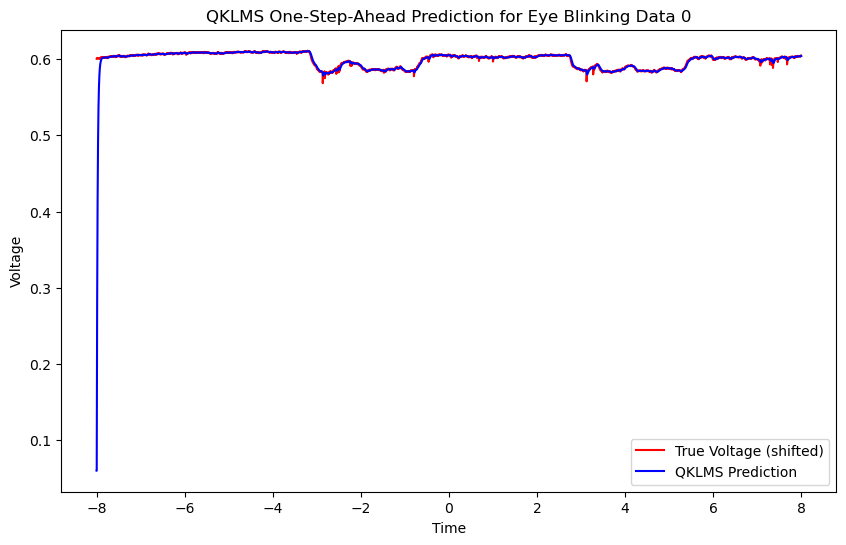

NMSE for eye_blinking1.csv: 0.029942768886943926
Training on file eye_blinking1.csv
Final number of centers in QKLMS codebook: 1


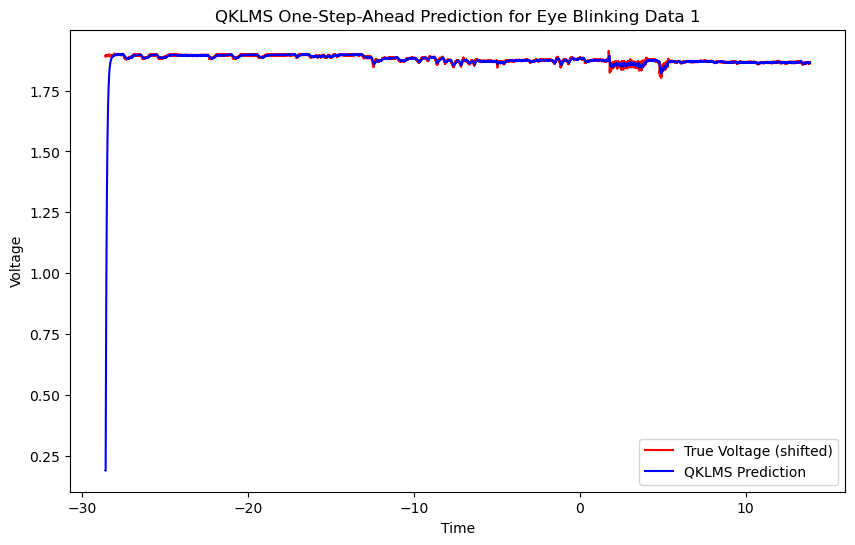

NMSE for eye_blinking2.csv: 0.024992716646635188
Training on file eye_blinking2.csv
Final number of centers in QKLMS codebook: 1


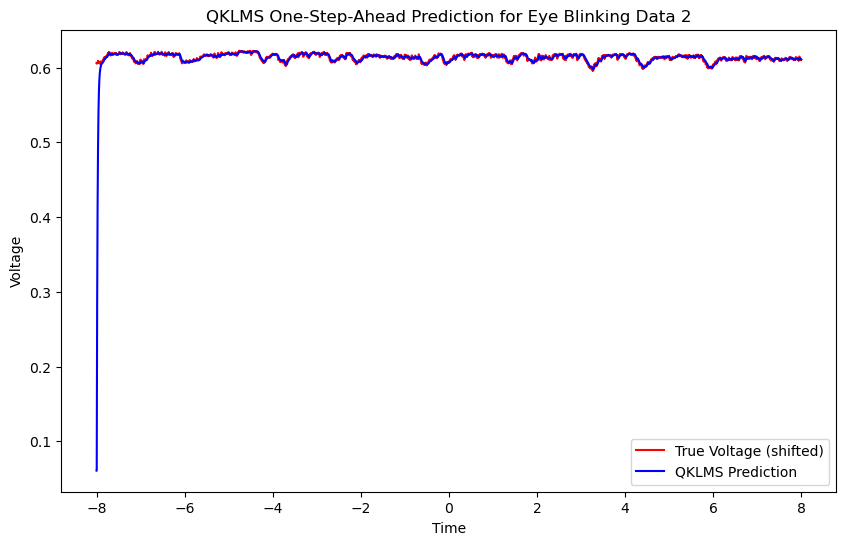

NMSE for eye_blinking3.csv: 0.03683509220751455
Training on file eye_blinking3.csv
Final number of centers in QKLMS codebook: 1


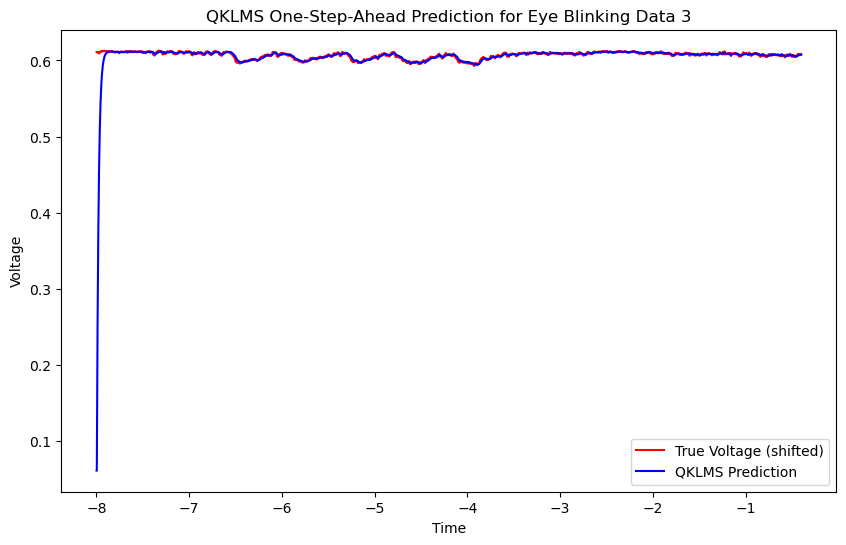

NMSE for eye_blinking4.csv: 0.03184050335044579
Training on file eye_blinking4.csv
Final number of centers in QKLMS codebook: 1


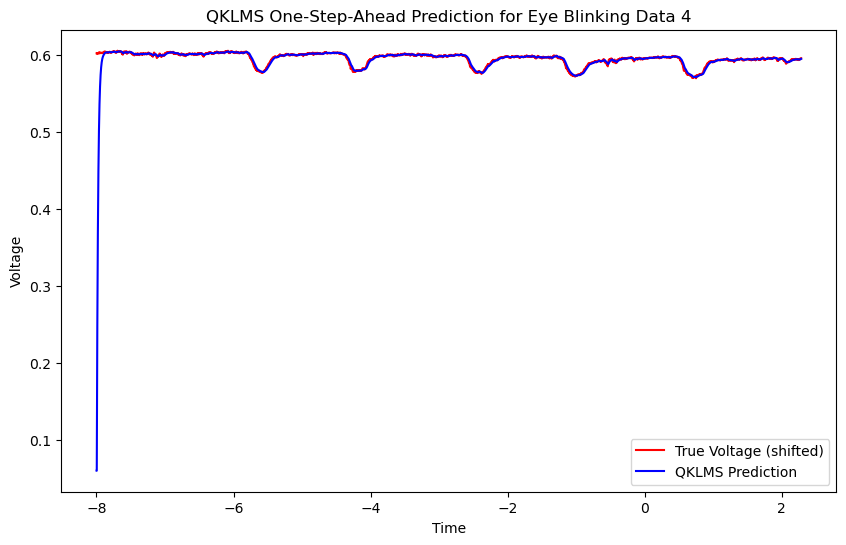

NMSE for eye_blinking5.csv: 0.0313977797858964
Training on file eye_blinking5.csv
Final number of centers in QKLMS codebook: 1


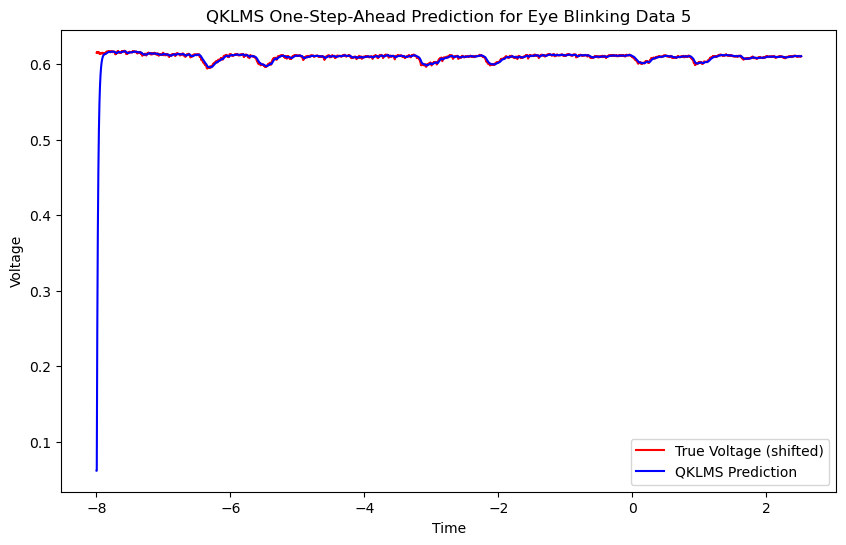

NMSE for eye_blinking6.csv: 0.026314483869865863
Training on file eye_blinking6.csv
Final number of centers in QKLMS codebook: 1


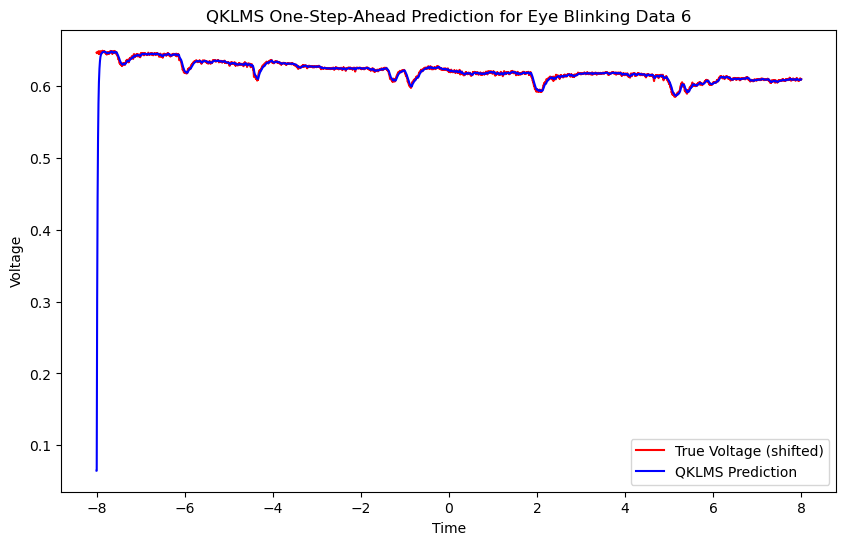

NMSE for eye_blinking7.csv: 0.027738019950941557
Training on file eye_blinking7.csv
Final number of centers in QKLMS codebook: 1


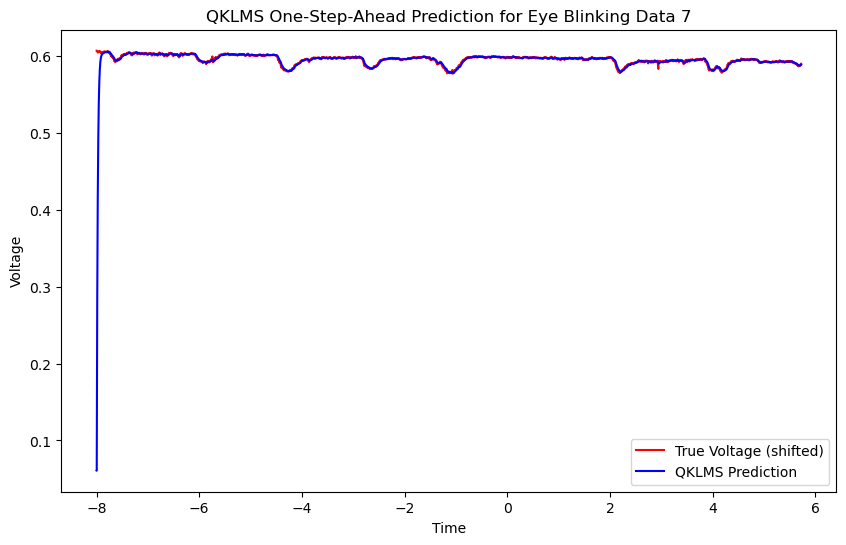

NMSE for eye_blinking8.csv: 0.02674377065403176
Training on file eye_blinking8.csv
Final number of centers in QKLMS codebook: 1


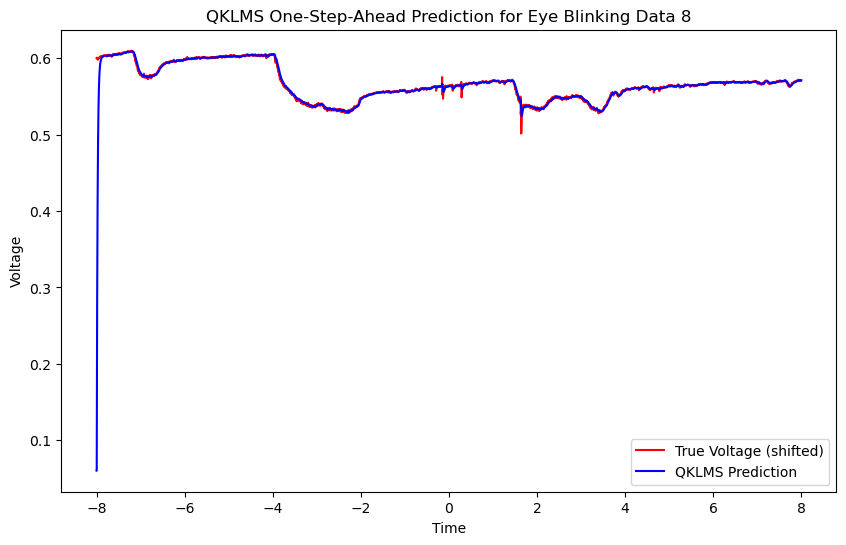

NMSE for eye_blinking9.csv: 0.02590817423321124
Training on file eye_blinking9.csv
Final number of centers in QKLMS codebook: 1


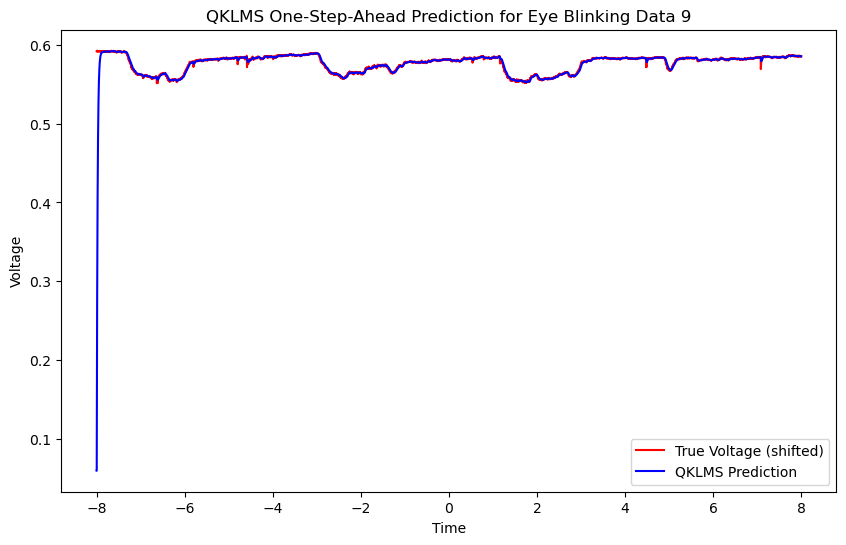

In [6]:
eta = 0.1       # Step size
sigma = 1.0     # Gaussian kernel width
epsilon = 0.2   # Quantization threshold

for i in range(10):
    # Load the data from the CSV file
    data = pd.read_csv(f'eye_blinking{i}.csv', delimiter=',')
    # Drop Channel2 if present
    if 'Channel2' in data.columns:
        data = data.drop(columns=['Channel2'])
        
    # Get voltage and time values
    voltage = data['Channel1'].values  # shape: (T,)
    time = data['Time'].values
    T = len(voltage)
    
    # For one-step-ahead prediction:
    #   Input u: voltage[0] to voltage[T-2]
    #   Target d: voltage[1] to voltage[T-1]
    u = voltage[:-1].reshape(-1, 1)  # shape: (T-1, 1)
    d = voltage[1:]                 # shape: (T-1,)
    
    # Run QKLMS on the current data
    y_hat, final_codebook, final_coeffs, e_history, _, _ = qklms_filter(u, d, eta, sigma, epsilon)

    NMSE = np.linalg.norm(e_history) / np.linalg.norm(u)
    print(f"NMSE for eye_blinking{i}.csv: {NMSE}")
    
    print(f"Training on file eye_blinking{i}.csv")
    print(f"Final number of centers in QKLMS codebook: {len(final_codebook)}")
    
    # Plot the true (shifted) voltage and QKLMS predictions
    plt.figure(figsize=(10, 6))
    plt.plot(time[1:], d, 'r', label='True Voltage (shifted)')
    plt.plot(time[1:], y_hat, 'b', label='QKLMS Prediction')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'QKLMS One-Step-Ahead Prediction for Eye Blinking Data {i}')
    plt.legend()
    plt.show()


### QKLMS Evaluation Experiment (C)

To use the C code, download the LSTM.C file, and compile with the corresponding compiler. For Linux, the command:
```
gcc QKLMS.C -o qklms -lm
./qklms
```

Can validate the results obtained above on your own dataset. For real-time functions, the ```apply_qklms``` function should be used in an online-fashion. This means, it can and should be used per input received.

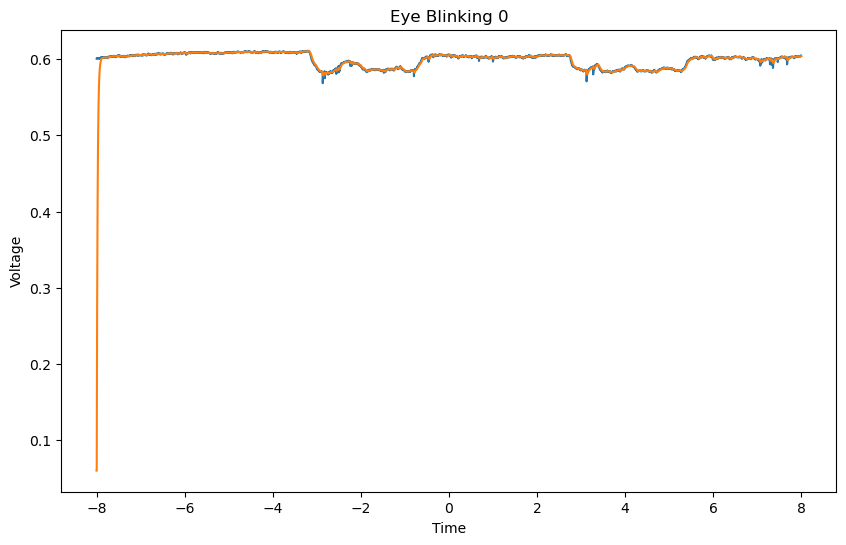

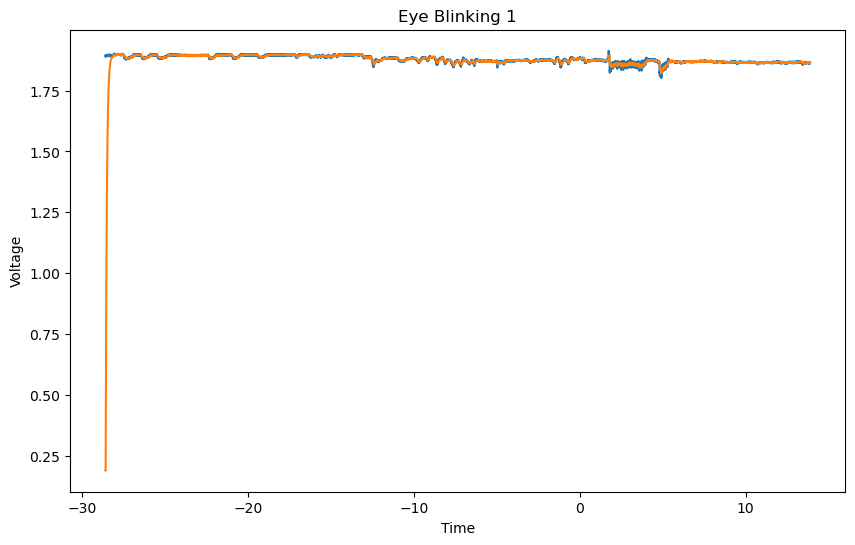

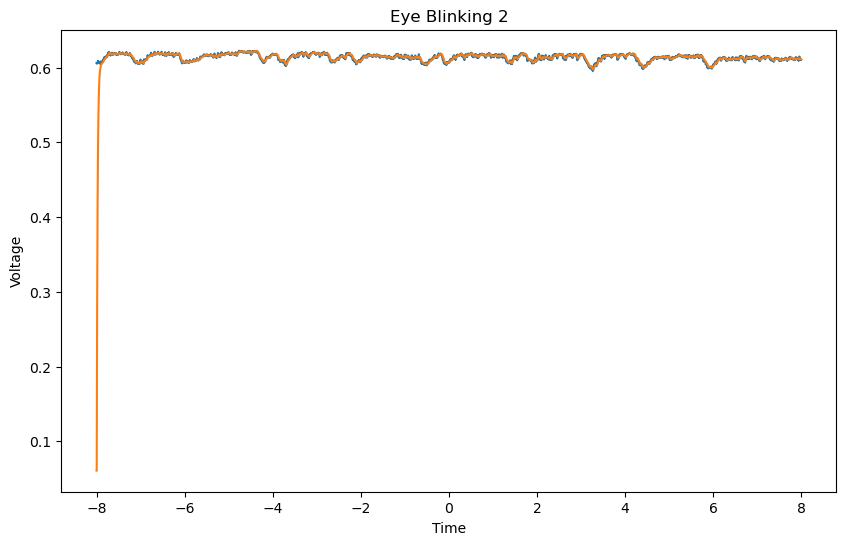

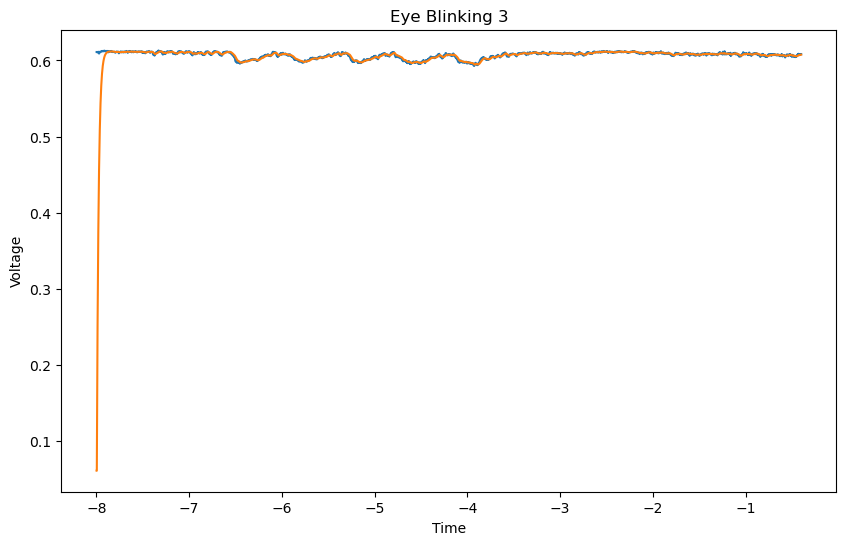

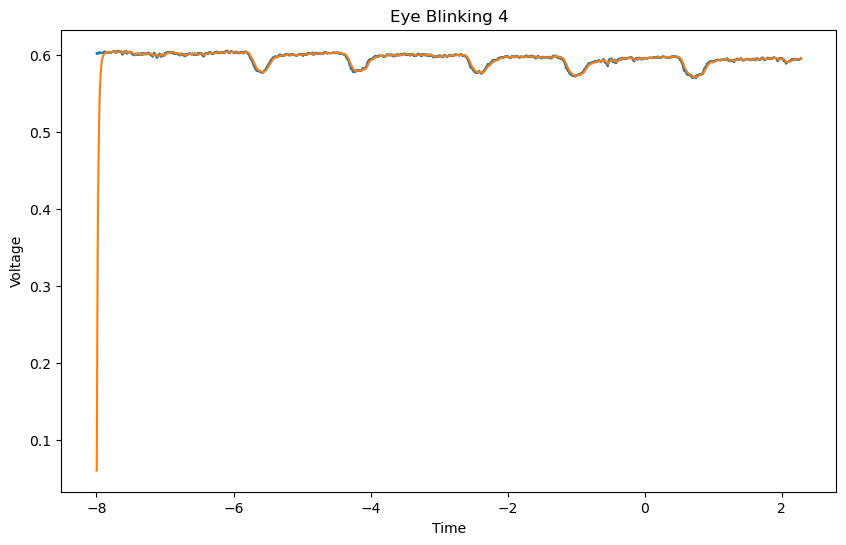

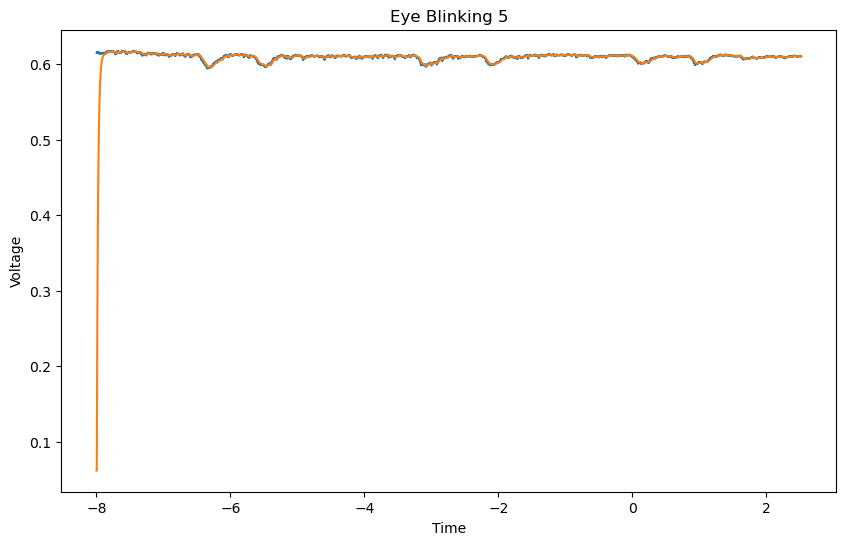

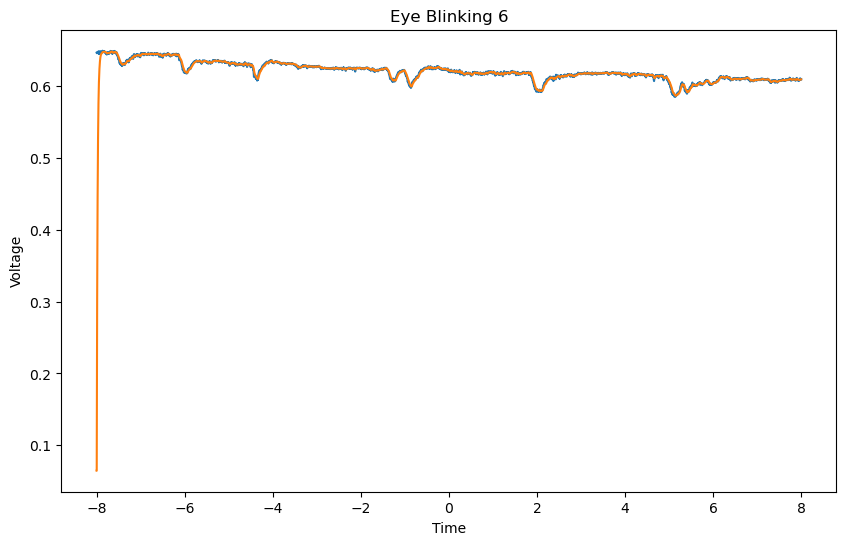

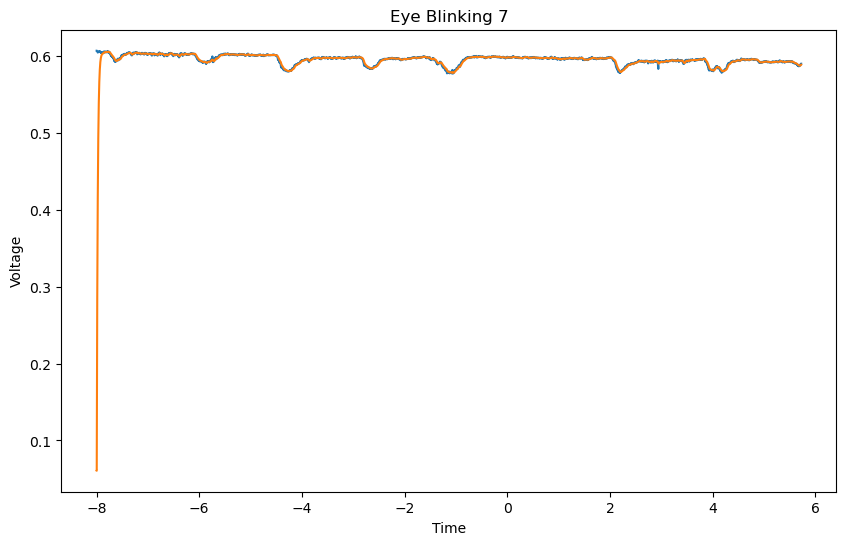

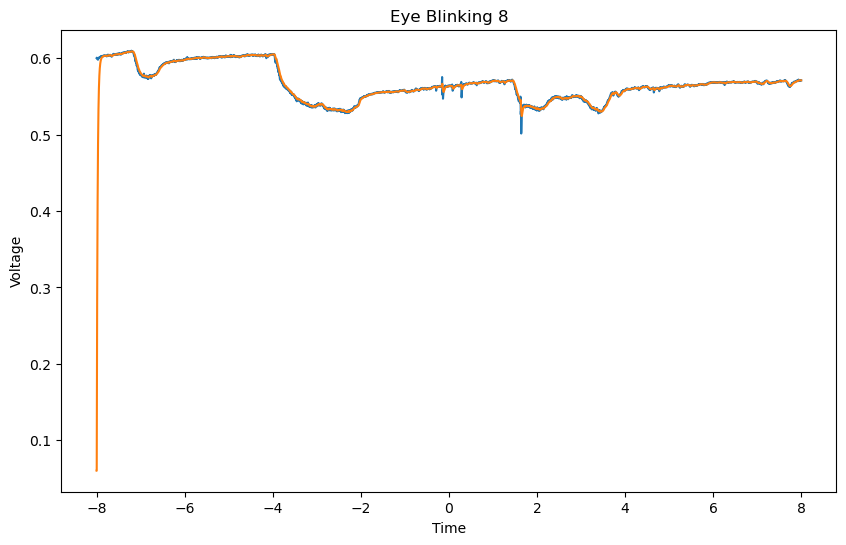

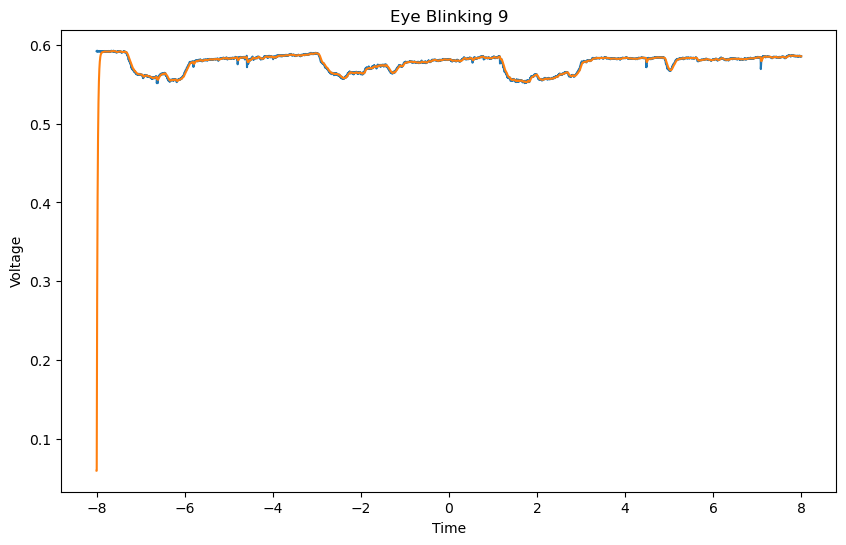

In [8]:
for i in range(10):
    data = pd.read_csv(f'output{i}.csv', delimiter=',')

    plt.figure(figsize=(10, 6))
    plt.plot(data['Time'], data['TrueVoltage'])
    plt.plot(data['Time'], data['Prediction'])

    plt.title(f'Eye Blinking {i}')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Blinking {i}')
    plt.show()
